![This is an image](Quant-Trading.jpg)

In [1]:
import warnings
warnings.filterwarnings('ignore')

from numpy import *
from pylab import *
from numpy.random import rand
import scipy.stats
import PoissonGenerator
import matplotlib.pyplot as plt

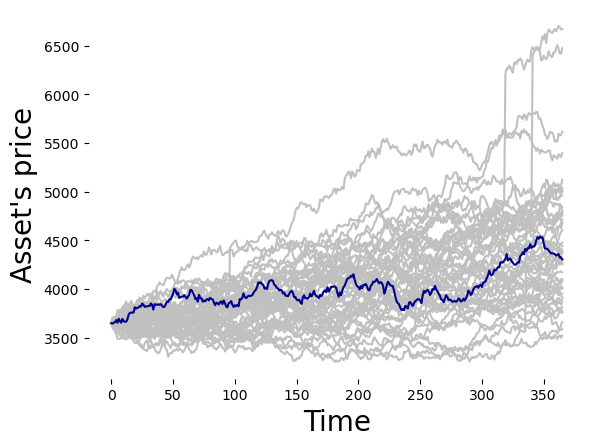

In [6]:
#Here we have the simulation of a Jump Difussion Process
#It can be in two different ways. The first one is with the size of the jumps distributed lognormally.
#The second one is more general. The example is shown for an exponential or a uniform distribution

########################################################################################################################################3
#First method: Yi have a lognormal distribution with parameters (a,b)
if True:
    lamda = 0.1                 #Average number of jumps
    T = 1                       #Time to maturity
    d = 365                     #Number of steps
    delta_t = T/d               #Step size
    M = 10**2                   #Number of paths
    a = 0.25                     #Average jump's size
    b = 0.05                     #Jump's standard deviation
    m = exp(a+0.5*b**2)-1       #m = Jump's average - 1. Since Yi is lognormal distributed, the average is exp(a+0.5b^2)

    r = 0.175                    #Interest rate
    sigma = 0.12                #Volatilidty
    S0 = 3650                   #Spot price
    

    #Random variables generation
    z1 = randn(M,d)                   #Random variable to generate brownian motion
    z2 = randn(M,d)                   #Random variable to generate jumps

    N = PoissonGenerator.Poisson(M,lamda*delta_t)            #Generate Poisson random variable
    for i in range(0,d-1):
        N = append(N,PoissonGenerator.Poisson(M,lamda*delta_t))

    N = resize(N,(M,d))

    J = a*N+b*sqrt(N)*z2               #Sum of the jump's logarithm. These are lognormal distributed
    x = zeros((M,d+1))
    x[:,0]=log(S0)
    
    #Generacion del path
    for j in range(0,d):
        x[:,j+1]= x[:,j] + (r-lamda*m-0.5*sigma**2)*delta_t+sigma*sqrt(delta_t)*z1[:,j]+J[:,j]

    path = exp(x)
    if True:
        #Plot first 50 paths
        plt.plot(path[0:50,:].transpose(),c='silver')
        plt.plot(path[0:1,:].transpose(),c='darkblue')
        ylabel("Asset's price",fontsize=20)
        xlabel("Time",fontsize=20)
        box(on=None)
        show()

###########################################################################################################################################################

if False:
#Second method - much more general. Yi is not necessarily lognormal distributed. In this example we are using
#jumps with uniform or exponential distribution. Recall that Yi can be interpreted as the return after the jump


    lamda = 0.1                         
    T = 1                               
    d = 365                              
    delta_t = T/d                       
    M = 10**2                           
    a = 5                               #If it is exponential: Average jump size, If it is uniform: Lower interval range
    b = 0                               #If it is exponential: 0, If it is uniform: Upper interval range
    dist = 'exponential'


    if dist == 'exponential':
        m = 1/a                 #Average. Depends on the exponencial or uniform distribution
    elif dist == 'uniform':
        m = 0.5*(a+b)-1

        
    r = 0.0175                    
    sigma = 0.12                 
    S0 = 3650                    
    K = 100

    #Random variable generation
    z1 = randn(M,d)                             

    N = PoissonGenerator.Poisson(M,lamda*delta_t)            
    for i in range(0,d-1):
        N = append(N,PoissonGenerator.Poisson(M,lamda*delta_t))

    N = resize(N,(M,d))
    J = zeros((M,d))

    #Loop to get J, which is the sum of the jumps
    for i in range(0,M):
        for j in range(0,d):
            if N[i,j] == 0:
                J[i,j] =0
            else:
                suma =0
                for k in range(0,int(N[i,j])):
                    if dist == 'exponential':
                        suma = suma+(-log(rand())/a)
                    elif dist == 'uniform':
                        suma = suma + log((a+rand()*(b-a)))               #generate uniform random variable in [a,b]
                J[i,j] = suma

    x = zeros((M,d+1))

    #Generate paths
    for j in range(0,d):
        x[:,j+1]= x[:,j] + (r-lamda*m-0.5*sigma**2)*delta_t+sigma*sqrt(delta_t)*z1[:,j]+J[:,j]

    path = S0*exp(x)
    if True:
        #Plot first 50 paths       
        plt.plot(path[0:50,:].transpose(),c='silver')
        plt.plot(path[0:1,:].transpose(),c='darkblue')
        ylabel("Asset's price",fontsize=20)
        xlabel("Time",fontsize=20)
        box(on=None)
        show()



If this content is helpful and you want to make a donation please click on the button

[![paypal](https://www.paypalobjects.com/en_US/i/btn/btn_donateCC_LG.gif)](https://www.paypal.com/cgi-bin/webscr?cmd=_s-xclick&hosted_button_id=29CVY97MEQ9BY)